# AIAp Miniproject 2

## Contents

- [Imports](#imports)

## Imports

In [76]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from keras import utils as keras_utils
import tensorflow as tf
import numpy as np

## Configs

In [77]:
SEED = 42

## Dataset

### b) Citation and description

For our project we used the following data:

- **Title:** Architectural Heritage Elements Dataset
- **Subtitle:** 128 (creative commons) revised
- **Version:** 1
- **Publication Date:** 2017-02-20
- **Author:** Jose Llamas
- **Organization:** Fundación CARTIF
- **Source:** https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip
- **Media:** .jpg in .zip
- **Download:** 2024-03-26

The raw data was extracted with Windows. We then added it to our ["AIAp Miniproject 2"](https://gitlab.ost.ch/sylvester.homberger/aiap-miniproject-2) repository on the Gitlab instance of OST.

This dataset consists of 10437 RGB 64x64 jpg images classified in 11 categories:
- Altar: 828 images
- Apse: 505 images
- Bell tower: 1057 images
- Column: 1914 images
- Dome (inner): 589 images
- Dome (outer): 1175 images
- Flying buttress: 405 images
- Gargoyle (and Chimera): 1562 images
- Portal: 307 images
- Stained glass: 998 images
- Vault: 1097 images

As "flying buttress" and "portal" do not satisfy the minimal samples requirement of 500, we manually moved them out of our dataset into a separate folder. Our adjusted dataset therefore fulfils the requirements:
- RGB images of 9 classes
- Each has more than 500 samples and the total is 9725 images
- They have a resolution of 64x64 pixels

### c) Load and split data

In [79]:

data_folder = Path(os.getcwd()).parent / "data"
raw_folder = data_folder / "raw" / "Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"

raw_train_val_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="training"
)

raw_test_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="validation"
)

raw_training_data, raw_validation_data = keras_utils.split_dataset(raw_train_val_data, left_size=0.8, shuffle=True)

label_to_class = raw_train_val_data.class_names
class_to_label = dict(zip(label_to_class, range(len(label_to_class))))

## Exploratory data analysis

### Plot a few images

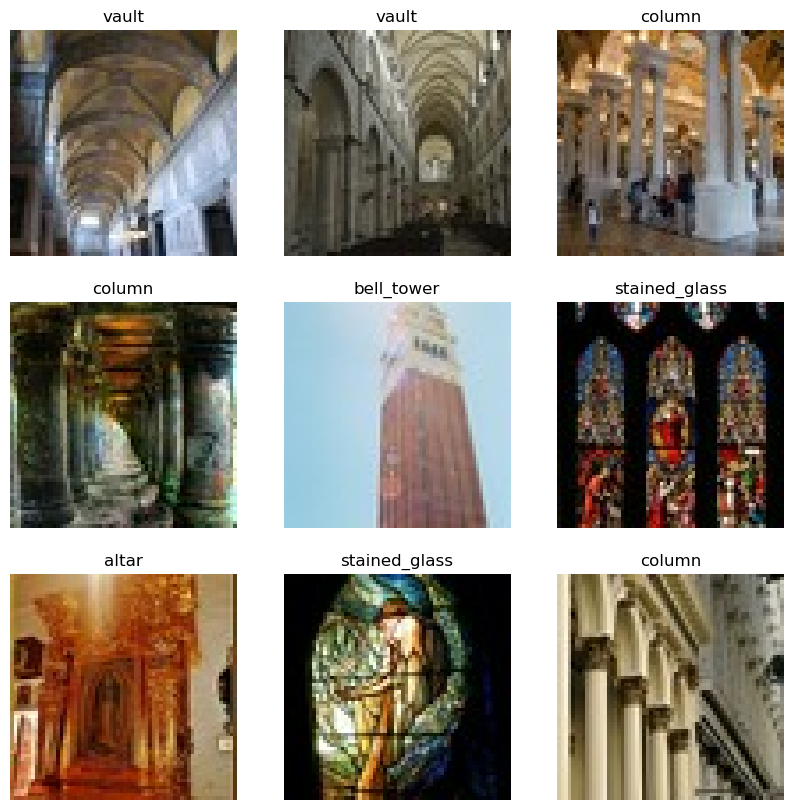

In [145]:
plt.figure(figsize=(10, 10))
for images, labels in raw_train_val_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label_to_class[labels[i]])
    plt.axis("off")

### Samples per class

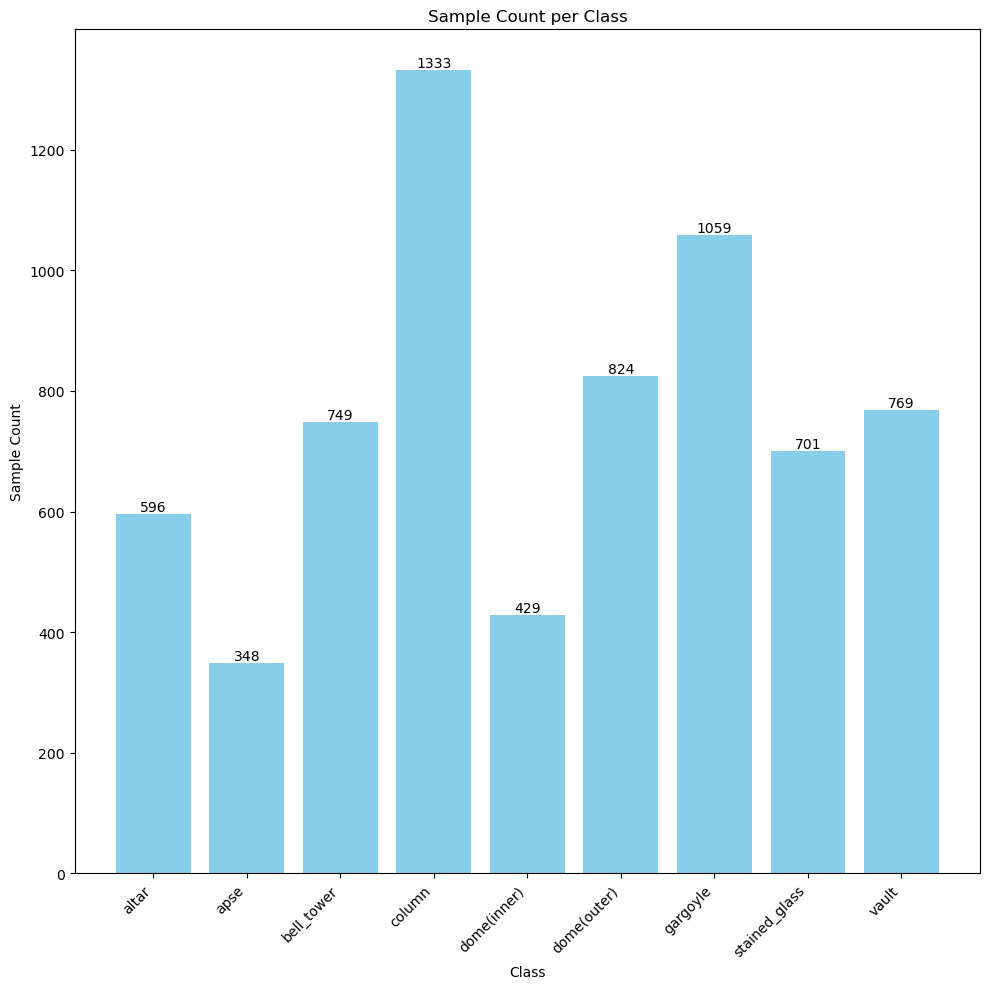

In [80]:
# Count samples per class
class_counts = raw_train_val_data.reduce(
    initial_state=tf.zeros(len(label_to_class), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(label_to_class)))

# Extract numbers
class_counts_values = [count.numpy() for count in class_counts]

# Plot samples per class
plt.figure(figsize=(10, 10))
bars = plt.bar(label_to_class, class_counts_values, color='skyblue')
plt.bar_label(bars, labels=class_counts_values, label_type='edge', color='black')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title('Sample Count per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


The dataset is not balanced. Classes need to be weighted for training.

### Distribution of values

Red range: 	 0.0  -  255.0
Green range: 	 0.0  -  255.0
Blue range: 	 0.0  -  255.0


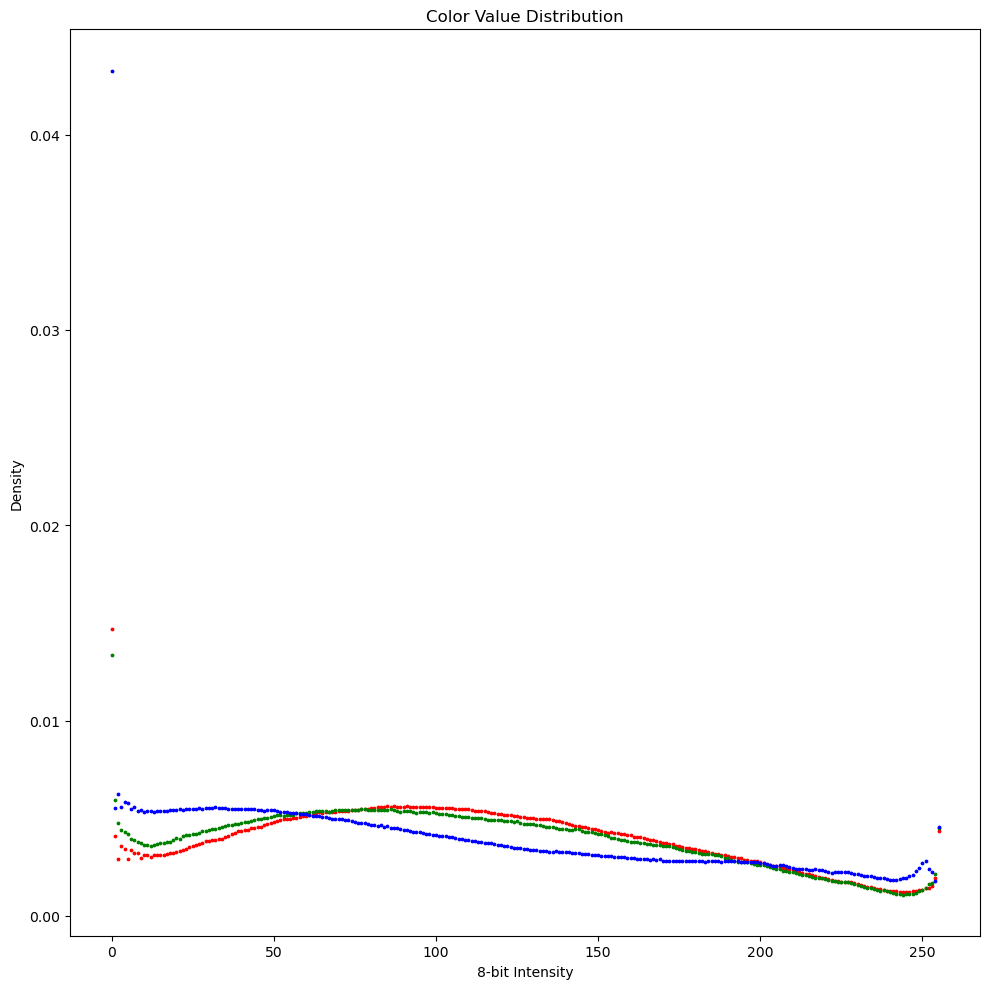

In [144]:
# Concatenate all images in the dataset
images_np = np.concatenate([images.numpy() for images, _ in raw_training_data])

# Reshape to (num_images * height * width, channels)
images_np = images_np.reshape(-1, images_np.shape[3])

# Extract RGB values
red_values = images_np[:, 0]
green_values = images_np[:, 1]
blue_values = images_np[:, 2]

# Get range of values
red_max = np.max(red_values)
red_min = np.min(red_values)
print("Red range: \t", red_min, " - ", red_max)
green_max = np.max(green_values)
green_min = np.min(green_values)
print("Green range: \t", green_min, " - ", green_max)
blue_max = np.max(blue_values)
blue_min = np.min(blue_values)
print("Blue range: \t", blue_min, " - ", blue_max)

# Calculate the distribution
red_distribution = np.histogram(red_values, bins=256, density=True)[0]
green_distribution = np.histogram(green_values, bins=256, density=True)[0]
blue_distribution = np.histogram(blue_values, bins=256, density=True)[0]

# Plot all color densities on the same plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(red_distribution)), red_distribution, color='red', s=3)
plt.scatter(range(len(green_distribution)), green_distribution, color='green', s=3)
plt.scatter(range(len(blue_distribution)), blue_distribution, color='blue', s=3)
plt.xlabel('8-bit Intensity')
plt.ylabel('Density')
plt.title('Color Value Distribution')
plt.tight_layout()

We observe significant peaks at the extreme ends of the value range (0 and 255). The underlying cause is unclear to us, as we did not generate the images ourselves. 

We observed a clear distinction in the distribution of blue intensity compared to that of red and green. While all colors demonstrate a decrease in density as intensity increases, there are notable variations among them. Specifically, red and green intensities seem to follow a somewhat normal distribution pattern, whereas blue intensity exhibits a nearly monotonic decline.

This decrease in density across intensities could potentially stem from heightened sensitivity of the camera equipment at higher levels, leading to a stretched scale. However, when examining the discrepancy between blue and the other colors, our initial online investigation did not provide immediate insights into the underlying cause of this disparity.

However, those phenomenona should not hinder meaningful model training, provided it does not systematically convey information regarding the classes.

Additionally, we need to rescale the value range from [0 - 255] to [0 - 1]. The below function will also be used for the test data later.

In [ ]:
def scale_image_dataset(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

training_data = scale_image_dataset(raw_training_data)
validation_data = scale_image_dataset(raw_validation_data)

## Architecture 1 (underfitting)

## Architecture 2 (overfitting)

## Architecture 2 (optimized)

## Quantification of the model performance

## Discussion